In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from solardatatools import signal_decompositions as sd

np.random.seed(12) # reload each time to get first instance of seed

# Set up simple numerical examples for tests

#  l2_l1d1_l2d2p365

In [2]:
    """
    This performs total variation filtering with the addition of a seasonal baseline fit. This introduces a new
    signal to the model that is smooth and periodic on a yearly time frame. This does a better job of describing real,
    multi-year solar PV power data sets, and therefore does an improved job of estimating the discretely changing
    signal.

    :param signal: A 1d numpy array (must support boolean indexing) containing the signal of interest
    :param c1: The regularization parameter to control the total variation in the final output signal
    :param c2: The regularization parameter to control the smoothness of the seasonal signal
    :return: A 1d numpy array containing the filtered signal
    """;

## Three-Component Signal 

In [2]:
from scipy import signal

t = np.linspace(0, 1000, 365*2)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
K, T = X_real.shape

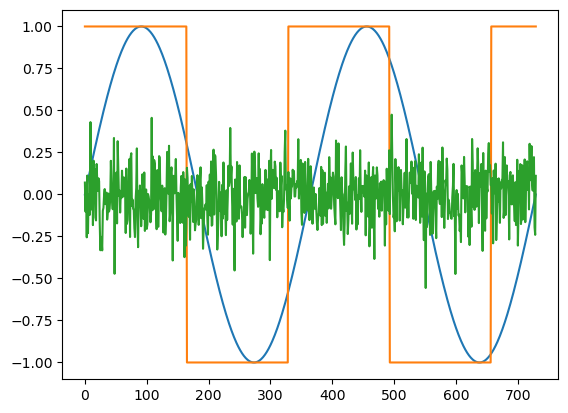

In [3]:
plt.plot(signal1)
plt.plot(signal2)
plt.plot(X_real[0])

In [4]:
# smooth + yearly periodic + gaussian noise signals
# t = np.linspace(0, 1000, 365*2)
# signal1 = np.sin(2 * np.pi * t * 1 / (500)) # sine wave, smooth periodic

# # piecewise constant 

# X_real = np.zeros((2, len(t)), dtype=float)
# X_real[0] = 0.3 * np.random.randn(len(signal1)) # noise in form of sigma * np.random.randn(...) + mu
# X_real[1] = signal1 

# y = np.sum(X_real, axis=0)

In [5]:
# plt.plot(y[365:])
# plt.plot(y[:-365])

In [6]:
# y = list(y[:365])
# y = y + y 

In [7]:
# yearly periodic
# plt.plot(y[365:])
# plt.plot(y[:-365])

## sav/load as df

In [3]:
fname = "test_l2_l1d1_l2d2p365_data_input.csv"
# try:
#     signal = pd.read_csv(fname)["test_signal"].array
#     test_df = pd.DataFrame(signal, columns=["test_signal"])
#     #df_full = pd.read_csv(fname)
# except FileNotFoundError:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)

In [4]:
test_df.head(1)

,test_signal
0,1.070948


### CVXPY exepcted output
Try OSQP, SCS, ECOS, and MOSEK and confirm that all that run give the same objective value

## start w/ signal <= 365

In [4]:
test_df = pd.DataFrame(y, columns=["test_signal"]).round(7)

In [5]:
signal_365 = test_df["test_signal"].array[:365]

### adjusted c1 from 10 to 2

In [6]:
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, c1=2, solver = "MOSEK")

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_365"]

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_mosek_365"]

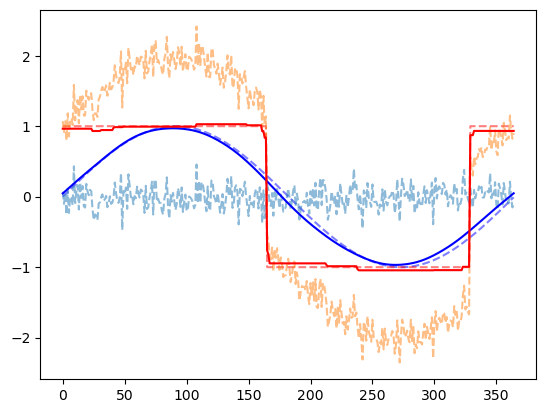

In [7]:
# tweak l1 params if off
plt.plot(signal1[:365], linestyle="--", alpha=0.5, color="blue")
plt.plot(signal2[:365], linestyle="--", alpha=0.5,  color="red")
plt.plot(X_real[0][:365],  linestyle="--", alpha=0.5)
plt.plot(test_df["test_signal"][:365], linestyle="--", alpha=0.5)

plt.plot(test_df["expected_s_seas_mosek_365"], color="blue")
plt.plot(test_df["expected_s_hat_mosek_365"], color="red")

In [8]:
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, c1=2, solver = "SCS")

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_scs_365"]

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_scs_365"]

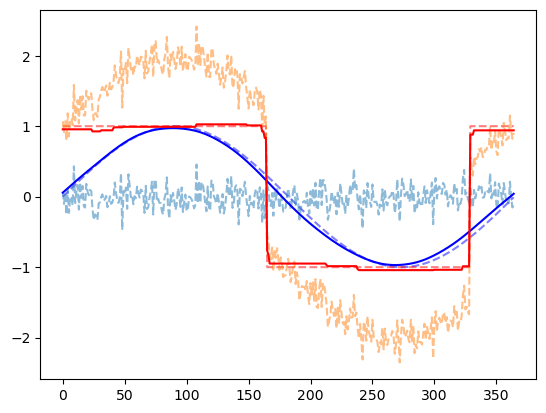

In [9]:
# tweak l1 params if off
plt.plot(signal1[:365], linestyle="--", alpha=0.5, color="blue")
plt.plot(signal2[:365], linestyle="--", alpha=0.5,  color="red")
plt.plot(X_real[0][:365],  linestyle="--", alpha=0.5)
plt.plot(test_df["test_signal"][:365], linestyle="--", alpha=0.5)

plt.plot(test_df["expected_s_seas_scs_365"], color="blue")
plt.plot(test_df["expected_s_hat_scs_365"], color="red")

In [10]:
# random weights 
rand_residual_weights = np.random.uniform(1, 2, len(signal_365)).round(7)
rand_tv_weights = np.random.uniform(1, 2, len(signal_365)-1).round(7)

In [11]:
cols = test_df.columns

test_df = pd.concat([test_df, pd.Series(rand_residual_weights)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(rand_tv_weights)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["rand_residual_weights_365", "rand_tv_weights_365"]

### add resuts w/ weights

In [12]:
# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, c1=2.5, solver = "MOSEK", residual_weights=test_df["rand_residual_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_rw_365", "expected_s_seas_mosek_rw_365"]

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, c1=2.5, solver = "MOSEK", tv_weights=test_df["rand_tv_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_tvw_365", "expected_s_seas_mosek_tvw_365"]

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365,  c1=2.5, solver = "SCS", residual_weights=test_df["rand_residual_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_scs_rw_365", "expected_s_seas_scs_rw_365"]

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, c1=2.5, solver = "SCS", tv_weights=test_df["rand_tv_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_scs_tvw_365", "expected_s_seas_scs_tvw_365"]

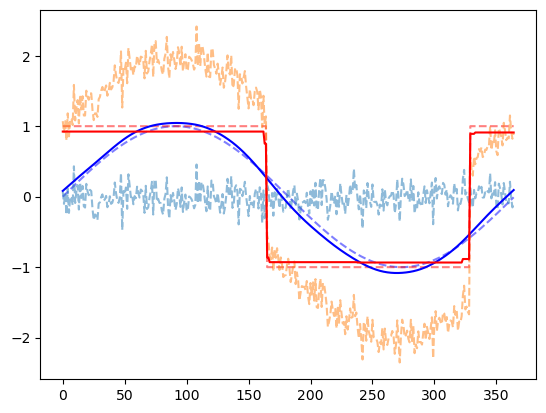

In [12]:
# tweak l1 params if off
plt.plot(signal1[:365], linestyle="--", alpha=0.5, color="blue")
plt.plot(signal2[:365], linestyle="--", alpha=0.5,  color="red")
plt.plot(X_real[0][:365],  linestyle="--", alpha=0.5)
plt.plot(test_df["test_signal"][:365], linestyle="--", alpha=0.5)

plt.plot(test_df["expected_s_seas_mosek_tvw_365"], color="blue")
plt.plot(test_df["expected_s_hat_mosek_tvw_365"], color="red")

### add transition pnt

In [13]:
# get indices of piecewise fn transitions

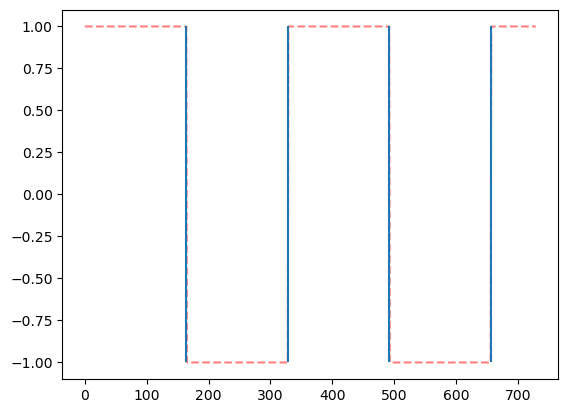

In [56]:
plt.plot(signal2, linestyle="--", alpha=0.5,  color="red")
plt.vlines(164, -1, 1)
plt.vlines(328, -1, 1)
plt.vlines(492, -1, 1)
plt.vlines(656, -1, 1)


In [13]:
idx = [164, 328]
cols = test_df.columns

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", transition_locs=idx)
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "SCS", transition_locs=idx)
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)

test_df.columns = list(cols) + ["expected_s_hat_mosek_transition_365", 
                                "expected_s_seas_mosek_transition_365",
                                "expected_s_hat_scs_transition_365",
                                "expected_s_seas_scs_transition_365"]

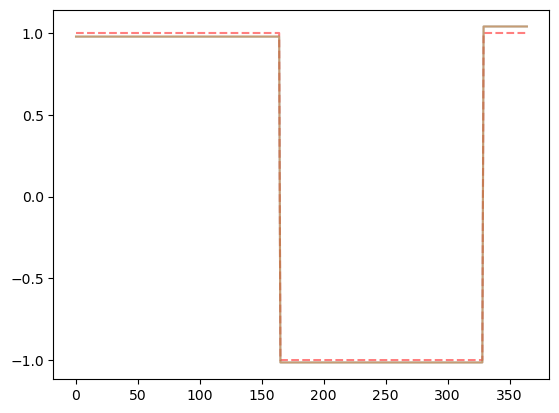

In [38]:
plt.plot(signal2[:365], linestyle="--", alpha=0.5,  color="red")
plt.plot(test_df["expected_s_hat_mosek_transition_365"], alpha=0.5,)
plt.plot(test_df["expected_s_hat_scs_transition_365"], alpha=0.5)

In [36]:
idx_wrong = [100, 308]
cols = test_df.columns

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", transition_locs=idx_wrong)
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "SCS", transition_locs=idx_wrong)
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)

test_df.columns = list(cols) + ["expected_s_hat_mosek_transition_wrong_365", 
                                "expected_s_seas_mosek_transition_wrong_365",
                                "expected_s_hat_scs_transition_wrong_365",
                                "expected_s_seas_scs_transition_wrong_365"]

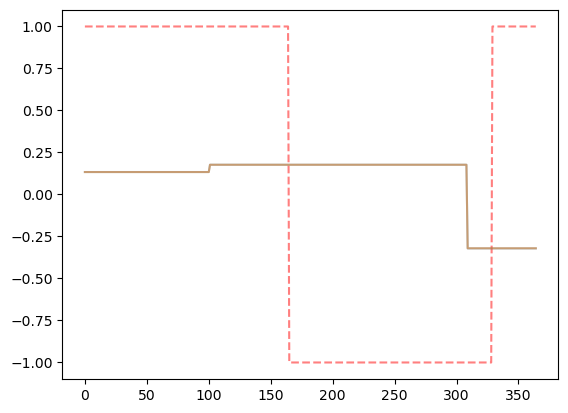

In [37]:
plt.plot(signal2[:365], linestyle="--", alpha=0.5,  color="red")
plt.plot(test_df["expected_s_hat_mosek_transition_wrong_365"], alpha=0.5,)
plt.plot(test_df["expected_s_hat_scs_transition_wrong_365"], alpha=0.5)

### max seas constraint  

In [15]:
cols = test_df.columns

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", seas_max=0.5) # is this reasonable?
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "SCS", seas_max=0.5) # is this reasonable?
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)

test_df.columns = list(cols) + ["expected_s_hat_mosek_seas_max_365", 
                                "expected_s_seas_mosek_seas_max_365",
                                "expected_s_hat_mosek_scs_max_365",
                                "expected_s_seas_mosek_scs_max_365"]

In [16]:
test_df = test_df.round(7)

## signal w/ len > 365

In [17]:
signal_730 = test_df["test_signal"].array
# cvxpy output w/ default args

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, c1=2, solver = "MOSEK")
test_df["expected_s_hat_mosek"] = s_hat
test_df["expected_s_seas_mosek"] = s_seas

# SCS 
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, c1=2, solver = "SCS")
test_df["expected_s_hat_scs"] = s_hat
test_df["expected_s_seas_scs"] = s_seas

#############################################################
# w/ random weights 
rand_residual_weights = np.random.uniform(1, 100, len(signal_730)).round(7)
rand_tv_weights = np.random.uniform(10, 200, len(signal_730)-1).round(7)
test_df["rand_residual_weights"] = rand_residual_weights

In [18]:
cols = test_df.columns 
test_df = pd.concat([test_df, pd.Series(rand_tv_weights)], ignore_index=True, axis=1)

test_df.columns = list(cols) + ["rand_tv_weights"]

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730,  c1=2.5, solver = "MOSEK", residual_weights=test_df["rand_residual_weights"])
test_df["expected_s_hat_mosek_rw"] = s_hat
test_df["expected_s_seas_mosek_rw"] = s_seas

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, c1=2.5, solver = "MOSEK", tv_weights=test_df["rand_tv_weights"].dropna())
test_df["expected_s_hat_mosek_tvw"] = s_hat
test_df["expected_s_seas_mosek_tvw"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, c1=2.5, solver = "SCS", residual_weights=test_df["rand_residual_weights"])
test_df["expected_s_hat_scs_rw"] = s_hat
test_df["expected_s_seas_scs_rw"] = s_seas

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, c1=2.5, solver = "SCS", tv_weights=test_df["rand_tv_weights"].dropna())
test_df["expected_s_hat_scs_tvw"] = s_hat
test_df["expected_s_seas_scs_tvw"] = s_seas

#############################################################
# random transition pnt
idx = [164, 328, 492, 656]

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK", transition_locs=idx)
test_df["expected_s_hat_mosek_transition_100"] = s_hat
test_df["expected_s_seas_mosek_transition_100"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "SCS", transition_locs=idx)
test_df["expected_s_hat_scs_transition_100"] = s_hat
test_df["expected_s_seas_scs_transition_100"] = s_seas

#############################################################
# max seas constraint

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK", seas_max=0.5) # is this reasonable?
test_df["expected_s_hat_mosek_seas_max"] = s_hat
test_df["expected_s_seas_mosek_seas_max"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "SCS", seas_max=0.5) # is this reasonable?
test_df["expected_s_hat_scs_seas_max"] = s_hat
test_df["expected_s_seas_scs_seas_max"] = s_seas



In [19]:
#############################################################
# Take first 300 days of dataset
indices = list([True]*300) + list([False]*(len(signal_730)-300))

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, c1=2, solver = "MOSEK", use_ixs=indices)
test_df["expected_s_hat_mosek_ixs"] = s_hat
test_df["expected_s_seas_mosek_ixs"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, c1=2, solver = "SCS", use_ixs=indices)
test_df["expected_s_hat_scs_ixs"] = s_hat
test_df["expected_s_seas_scs_ixs"] = s_seas


In [27]:
#############################################################
# yearly periodic constraint, len has to be >365

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730,  c1=1, solver = "MOSEK", yearly_periodic=True)
test_df["expected_s_hat_mosek_yearly_periodic"] = s_hat
test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730,  c1=1, solver = "SCS", yearly_periodic=True)
test_df["expected_s_hat_scs_yearly_periodic"] = s_hat
test_df["expected_s_seas_scs_yearly_periodic"] = s_seas

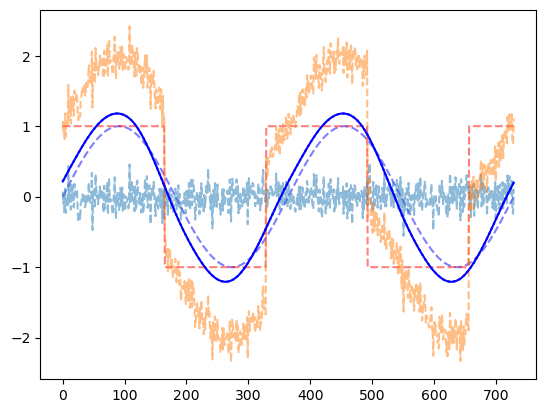

In [28]:
# tweak l1 params if off
plt.plot(signal1, linestyle="--", alpha=0.5, color="blue")
plt.plot(signal2, linestyle="--", alpha=0.5,  color="red")
plt.plot(X_real[0],  linestyle="--", alpha=0.5)
plt.plot(test_df["test_signal"], linestyle="--", alpha=0.5)

plt.plot(test_df["expected_s_seas_mosek_yearly_periodic"], color="blue")
plt.plot(test_df["expected_s_seas_scs_yearly_periodic"], color="blue", linestyle=":")

In [29]:
test_df = test_df.round(7)
test_df

,test_signal,expected_s_hat_mosek_365,expected_s_seas_mosek_365,expected_s_hat_scs_365,expected_s_seas_scs_365,rand_residual_weights_365,rand_tv_weights_365,expected_s_hat_mosek_rw_365,expected_s_seas_mosek_rw_365,expected_s_hat_mosek_tvw_365,...,expected_s_hat_scs_seas_max,expected_s_seas_scs_seas_max,expected_s_hat_mosek_ixs,expected_s_seas_mosek_ixs,expected_s_hat_scs_ixs,expected_s_seas_scs_ixs,expected_s_hat_mosek_yearly_periodic,expected_s_seas_mosek_yearly_periodic,expected_s_hat_scs_yearly_periodic,expected_s_seas_scs_yearly_periodic
0,1.070948,0.964178,0.045958,0.955368,0.056586,1.901030,1.042992,0.957599,0.044934,0.923493,...,0.955788,0.318985,1.076215,-0.045410,1.078233,-0.047198,0.800014,0.216540,0.800101,0.216595
1,0.915023,0.964178,0.061677,0.955368,0.072144,1.206654,1.586453,0.957599,0.060643,0.923493,...,0.955788,0.326297,1.076215,-0.036171,1.078233,-0.038022,0.800014,0.233118,0.800102,0.233210
2,1.070835,0.964178,0.077398,0.955368,0.087703,1.492222,1.282554,0.957599,0.076357,0.923493,...,0.955788,0.333404,1.076215,-0.026881,1.078233,-0.028795,0.800014,0.249636,0.800102,0.249758
3,0.796580,0.964178,0.093120,0.955368,0.103262,1.659901,1.175179,0.957599,0.092078,0.923493,...,0.955788,0.340329,1.076215,-0.017542,1.078233,-0.019519,0.800014,0.266099,0.800102,0.266244
4,1.181868,0.964178,0.108841,0.955368,0.118821,1.820012,1.559077,0.957599,0.107810,0.923493,...,0.955788,0.347090,1.076215,-0.008157,1.078233,-0.010197,0.800014,0.282511,0.800102,0.282670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1.060841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.609065,0.276328,-1.467238,-0.090353,-1.468650,-0.091828,0.800014,0.132007,0.800100,0.131816
726,1.170515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.609065,0.285516,-1.467238,-0.081484,-1.468650,-0.083021,0.800014,0.149084,0.800100,0.148940
727,0.770791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.609065,0.294375,-1.467238,-0.072559,-1.468650,-0.074159,0.800014,0.166076,0.800100,0.165983
728,0.742476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.609065,0.302932,-1.467238,-0.063579,-1.468650,-0.065242,0.800014,0.182990,0.800100,0.182949


In [20]:
#test_df = test_df.astype(float).round(7)

In [39]:
test_df.to_csv(fname, float_format='%.7f')

# l1_l2d2p365

In [8]:
    """
    for a list of available solvers, see:
        https://www.cvxpy.org/tutorial/advanced/index.html#solve-method-options

    :param signal: 1d numpy array
    :param use_ixs: optional index set to apply cost function to
    :param c1: float
    :param solver: string
    :return: median fit with seasonal baseline removed
    """;

In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from solardatatools import signal_decompositions as sd

np.random.seed(12) # reload each time to get first instance of seed

In [24]:
# smooth + yearly periodic + gaussian noise signals
t = np.linspace(0, 1000, 600)
signal1 = np.sin(2 * np.pi * t * 1 / (150)) # sine wave, smooth periodic

X_real = np.zeros((2, len(t)), dtype=float)
X_real[0] = 0.3 * np.random.randn(len(signal1)) # noise in form of sigma * np.random.randn(...) + mu
X_real[1] = signal1 


signal = np.sum(X_real, axis=0)

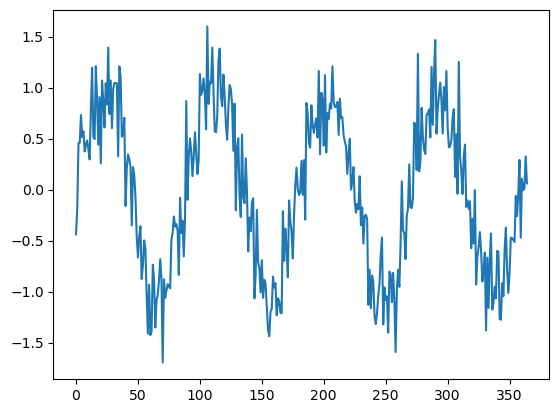

In [17]:
plt.plot(signal[:365])

In [ ]:
# use_ixs=None, c1=1e3, yearly_periodic=True
# <365 and >365

In [25]:
fname = "test_l1_l2d2p365_data_input.csv"
try:
    signal = pd.read_csv(fname)["test_signal"].array
    test_df = pd.DataFrame(signal, columns=["test_signal"])
except FileNotFoundError:
    test_df = pd.DataFrame(signal, columns=["test_signal"])

# cvxpy output w/ default args

# MOSEK
s_hat, s_seas = sd.l1_l2d2p365(signal, solver = "MOSEK")
test_df["expected_s_hat_mosek"] = s_hat
test_df["expected_s_seas_mosek"] = s_seas

# SCS 
s_hat, s_seas = sd.l1_l2d2p365(signal, solver = "SCS")
test_df["expected_s_hat_scs"] = s_hat
test_df["expected_s_seas_scs"] = s_seas

#############################################################
# Take first year of dataset
indices = list([True]*365) + list([False]*235)

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal, solver = "MOSEK", use_ixs=indices)
df_full["expected_s_hat_mosek_ixs"] = s_hat
df_full["expected_s_seas_mosek_ixs"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal, solver = "SCS", use_ixs=indices)
df_full["expected_s_hat_scs_ixs"] = s_hat
df_full["expected_s_seas_scs_ixs"] = s_seas

#############################################################
# yearly periodic constraint, len has to be >365

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal, solver = "MOSEK", yearly_periodic=True)
df_full["expected_s_hat_mosek_yearly_periodic"] = s_hat
df_full["expected_s_seas_mosek_yearly_periodic"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal, solver = "SCS", yearly_periodic=True)
df_full["expected_s_hat_mosek_yearly_periodic"] = s_hat
df_full["expected_s_seas_mosek_yearly_periodic"] = s_seas

ValueError: too many values to unpack (expected 2)